# Video stream train

In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime

import tensorflow as tf

# Keras module and tools
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout, RandomFlip
from keras.metrics import sparse_categorical_accuracy, sparse_top_k_categorical_accuracy
from keras.losses import sparse_categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras_cv.layers import RandomCutout
import keras_tuner

2023-06-13 14:10:24.005283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hci/miniconda3/envs/emotion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [2]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6} # to match the audio stream labels
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}

path_frames_face_BW = "Datasets/RAVDESS_frames_face_BW/"
path_frames = "Datasets/RAVDESS_frames/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

batch_size = 64
num_classes = len(emotions)

val_actors = ['19', '20']
test_actors = ['21', '22', '23', '24']

## Model 4: 112x112 BW Faces

### Dataset creation

In [3]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(path_frames_face_BW):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [19]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    print(type(batch_size))
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 
    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]
    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(images)
    # labels = [elem for elem in labels]
    # labels = tf.data.Dataset.from_tensor_slices(labels)

    # ds = tf.data.Dataset.zip((images, labels))
    # ds = configure_for_performance(ds)

    # frame_number = len(filenames_sampled)
    # step_per_epoch = frame_number // batch_size
    # print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    # return ds, step_per_epoch

In [20]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


TypeError: cannot unpack non-iterable NoneType object

In [12]:
examples = train_ds.unbatch().take(1)
i=''
j=0
for i in examples:
   j+=1
print(i[0])

2023-06-13 14:21:27.612637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [40480]
	 [[{{node Placeholder/_0}}]]
2023-06-13 14:21:27.612871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [40480]
	 [[{{node Placeholder/_4}}]]


tf.Tensor(
[[[0.984375  ]
  [0.9736328 ]
  [0.80578613]
  ...
  [0.9588623 ]
  [0.9824219 ]
  [0.9873047 ]]

 [[0.9863281 ]
  [0.96484375]
  [0.5627136 ]
  ...
  [0.9362793 ]
  [0.9814453 ]
  [0.9873047 ]]

 [[0.98339844]
  [0.95410156]
  [0.34506226]
  ...
  [0.83325195]
  [0.96484375]
  [0.9892578 ]]

 ...

 [[0.98535156]
  [0.9863281 ]
  [0.98828125]
  ...
  [0.98828125]
  [0.9921875 ]
  [0.98828125]]

 [[0.9873047 ]
  [0.9873047 ]
  [0.98828125]
  ...
  [0.9902344 ]
  [0.9921875 ]
  [0.98828125]]

 [[0.98828125]
  [0.98828125]
  [0.98828125]
  ...
  [0.98828125]
  [0.9921875 ]
  [0.98828125]]], shape=(112, 112, 1), dtype=float32)


In [7]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 5376 
batch size: 64 
batch number: 84


#### Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomCutout(0.4, 0.4, fill_mode="constant", fill_value=0.0, seed=None)
])

#### Examples

2023-06-13 14:22:02.367345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [40480]
	 [[{{node Placeholder/_0}}]]
2023-06-13 14:22:02.367575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [40480]
	 [[{{node Placeholder/_4}}]]


tf.Tensor(1, shape=(), dtype=int32)


(-0.5, 111.5, 111.5, -0.5)

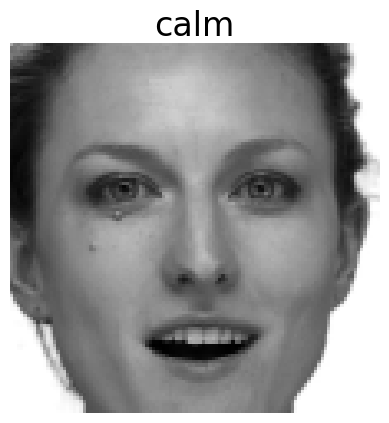

In [13]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[1])
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
# plt.savefig('Plots/model4_input.png')

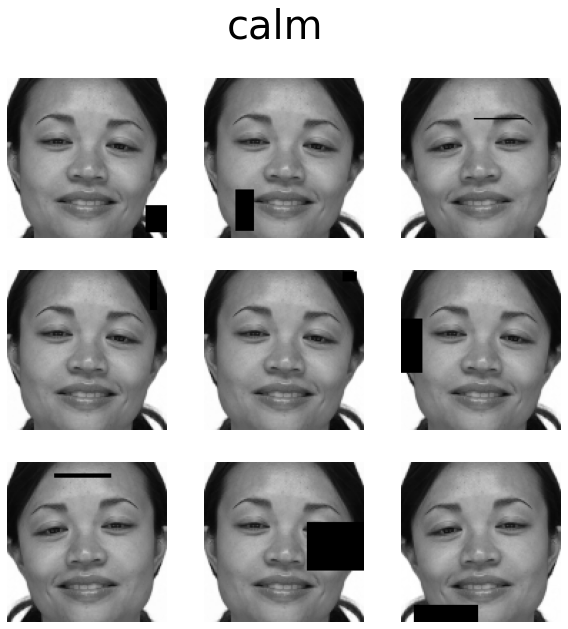

In [79]:
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")
plt.savefig('Plots/model4_augmentation.png')

### Net Architecture

In [10]:
# frame_type = ''
epochs = 10
lr = 0.001
momentum = 0.5

In [11]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [12]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation(x)

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_0')(x)
x = BatchNormalization(name='batchnorm_0')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_0')(x)

x = Conv2D(filters=64, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_1')(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(x)

x = Dropout(0.5, name='dropout_1')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_2')(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(x)

x = Dropout(0.5, name='dropout_2')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_3')(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(x)

x = Dropout(0.5, name='dropout_3')(x)

# x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_4')(x)
# x = BatchNormalization(name='batchnorm_x')(x)
# x = Activation('elu')(x)
# x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_4')(x)

# x = Dropout(0.5, name='dropout_4')(x)

x = Flatten(name='flatten')(x)
x = Dense(128, kernel_initializer='he_normal', name='dense_1')(x)
x = BatchNormalization(name='batchnorm_4')(x)
x = Activation('elu')(x)

x = Dropout(0.6, name='dropout_4')(x)

x = Dense(num_classes, activation='softmax', name='out_layer')(x)

output = x

net_4 = Model(inputs=input, outputs=output)
net_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 1)       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                             

In [13]:
net_4.compile(
        optimizer = Adam(learning_rate=lr),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss = sparse_categorical_crossentropy,
        metrics = [sparse_categorical_accuracy],
    )

### Training

In [14]:
history_4 = net_4.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[save_best],
                    verbose=1)

Epoch 1/10


2023-06-08 21:16:45.170382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [40480]
	 [[{{node Placeholder/_4}}]]
2023-06-08 21:16:45.170589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [40480]
	 [[{{node Placeholder/_0}}]]


632/632 [==============================] - ETA: 0s - loss: 1.5229 - sparse_categorical_accuracy: 0.4640

2023-06-08 21:21:05.788532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5376]
	 [[{{node Placeholder/_0}}]]
2023-06-08 21:21:05.788828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5376]
	 [[{{node Placeholder/_4}}]]


632/632 [==============================] - 300s 472ms/step - loss: 1.5229 - sparse_categorical_accuracy: 0.4640 - val_loss: 2.1320 - val_sparse_categorical_accuracy: 0.3292
Epoch 2/10
632/632 [==============================] - 305s 483ms/step - loss: 0.8982 - sparse_categorical_accuracy: 0.6738 - val_loss: 2.0305 - val_sparse_categorical_accuracy: 0.4014
Epoch 3/10
632/632 [==============================] - 302s 478ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.7514 - val_loss: 1.8067 - val_sparse_categorical_accuracy: 0.4613
Epoch 4/10
632/632 [==============================] - 302s 477ms/step - loss: 0.5702 - sparse_categorical_accuracy: 0.7970 - val_loss: 2.3856 - val_sparse_categorical_accuracy: 0.4044
Epoch 5/10
632/632 [==============================] - 300s 475ms/step - loss: 0.4907 - sparse_categorical_accuracy: 0.8241 - val_loss: 2.4790 - val_sparse_categorical_accuracy: 0.3988
Epoch 6/10
632/632 [==============================] - 303s 479ms/step - loss: 0.4260 - spar

### Evaluation

In [15]:
net_4.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

84/84 [==============================] - 38s 446ms/step - loss: 2.4784 - sparse_categorical_accuracy: 0.4293


[2.478433847427368, 0.4293154776096344]

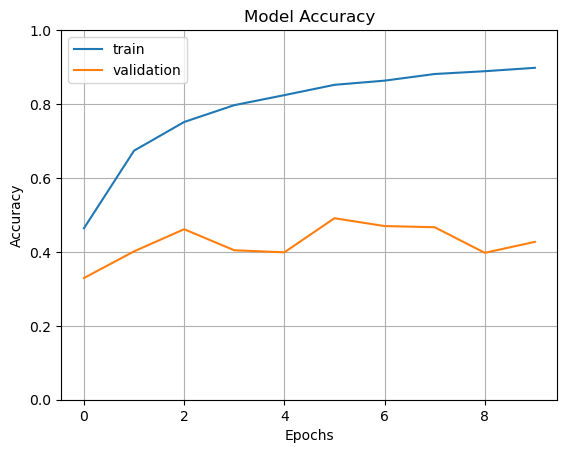

In [16]:
fig1 = plt.gcf()
plt.plot(history_4.history['sparse_categorical_accuracy'])
plt.plot(history_4.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model4_accuracy.png')
plt.show()

In [17]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net_4(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.45      0.50       768
           1       0.31      0.99      0.47       768
           2       0.82      0.38      0.52       768
           3       0.34      0.14      0.20       768
           4       0.73      0.37      0.49       768
           5       0.40      0.58      0.47       768
           6       0.44      0.07      0.13       768

    accuracy                           0.43      5376
   macro avg       0.51      0.43      0.40      5376
weighted avg       0.51      0.43      0.40      5376



## Model 5: 112x112 BW Faces (normalized with mean_face)

### Dataset creation

In [18]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(path_frames_face_BW):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [19]:
mean_face = np.load('Other/mean_face.npy')
mean_face = tf.convert_to_tensor(mean_face, dtype=tf.float32)

In [20]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    image = image - mean_face                                                       # subctract mean face
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])                         # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [21]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (112, 112, 1)
frames number: 40480 
batch size: 64 
batch number: 632


In [22]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 5376 
batch size: 64 
batch number: 84


#### Augmentation

In [23]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    # RandomCutout(0.4, 0.4, fill_mode="constant", fill_value=0.0, seed=None)
])

#### Examples

2023-06-09 12:24:42.900416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype int32 and shape [40480]
	 [[{{node Placeholder/_5}}]]
2023-06-09 12:24:42.900670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype int32 and shape [40480]
	 [[{{node Placeholder/_5}}]]


(112, 112, 1)


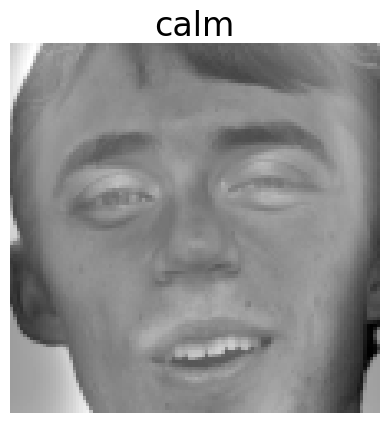

In [24]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
plt.savefig('Plots/model5_input.png')

2023-06-09 12:24:45.420959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype int32 and shape [40480]
	 [[{{node Placeholder/_5}}]]
2023-06-09 12:24:45.421244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype int32 and shape [40480]
	 [[{{node Placeholder/_5}}]]


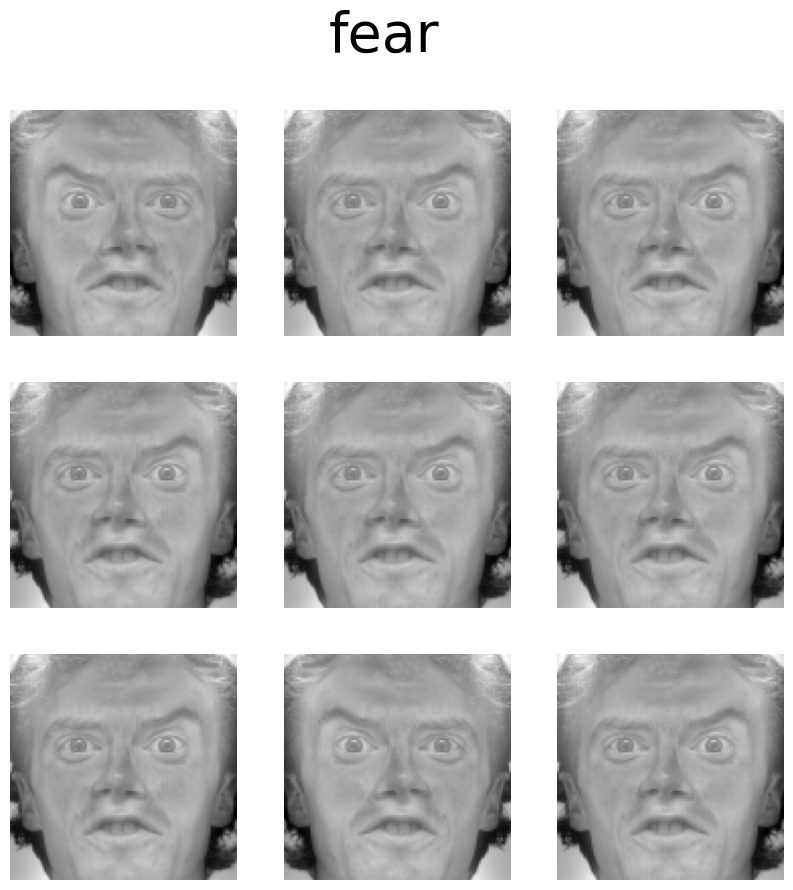

In [25]:
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")
# plt.savefig('Plots/model5_augmentation.png')

### Net Architecture

In [26]:
# frame_type = ''
epochs = 10
lr = 0.001
momentum = 0.5

In [27]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [28]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation(x)

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_0')(x)
x = BatchNormalization(name='batchnorm_0')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_0')(x)

x = Conv2D(filters=64, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_1')(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(x)

x = Dropout(0.4, name='dropout_1')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_2')(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(x)

x = Dropout(0.4, name='dropout_2')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_3')(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(x)

x = Dropout(0.5, name='dropout_3')(x)

x = Flatten(name='flatten')(x)
x = Dense(128, kernel_initializer='he_normal', name='dense_1')(x)
x = BatchNormalization(name='batchnorm_4')(x)
x = Activation('elu')(x)

x = Dropout(0.6, name='dropout_4')(x)

x = Dense(num_classes, activation='softmax', name='out_layer')(x)

output = x

net_5 = Model(inputs=input, outputs=output)
net_5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 112, 112, 1)       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation_5 (Activation)   (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                           

In [29]:
net_5.compile(
        optimizer = Adam(learning_rate=lr),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss = sparse_categorical_crossentropy,
        metrics = [sparse_categorical_accuracy],
    )

### Hyper-Parameters optimization

In [133]:
# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     objective="val_sparse_categorical_accuracy",
#     # max_trials=3,
#     executions_per_trial=1,
#     overwrite=True,
# )

# tuner.search_space_summary()

In [134]:
# tuner.search(train_ds,
#              epochs=3,
#              validation_data=val_ds,
#              batch_size=batch_size,
#              steps_per_epoch=step_per_epoch_train,
#              validation_steps=step_per_epoch_val)

In [135]:
# tuner.get_best_hyperparameters()[0].values

In [136]:
# best_model = tuner.get_best_models(num_models=1)[0]
# # Build the model.
# # Needed for `Sequential` without specified `input_shape`.
# best_model.build()
# # best_model.summary()

### Training

In [30]:
history_5 = net_5.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[save_best],
                    verbose=1)

Epoch 1/10


2023-06-09 12:24:58.419020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [112,112,1]
	 [[{{node Placeholder/_2}}]]
2023-06-09 12:24:58.419318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [112,112,1]
	 [[{{node Placeholder/_2}}]]


632/632 [==============================] - ETA: 0s - loss: 1.1275 - sparse_categorical_accuracy: 0.6069

2023-06-09 12:29:18.540283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype int32 and shape [5376]
	 [[{{node Placeholder/_5}}]]
2023-06-09 12:29:18.540751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype int32 and shape [5376]
	 [[{{node Placeholder/_5}}]]


632/632 [==============================] - 298s 470ms/step - loss: 1.1275 - sparse_categorical_accuracy: 0.6069 - val_loss: 2.8223 - val_sparse_categorical_accuracy: 0.3172
Epoch 2/10
632/632 [==============================] - 305s 482ms/step - loss: 0.6106 - sparse_categorical_accuracy: 0.7835 - val_loss: 2.2896 - val_sparse_categorical_accuracy: 0.4208
Epoch 3/10
632/632 [==============================] - 300s 475ms/step - loss: 0.4522 - sparse_categorical_accuracy: 0.8422 - val_loss: 2.3340 - val_sparse_categorical_accuracy: 0.4291
Epoch 4/10
632/632 [==============================] - 303s 480ms/step - loss: 0.3693 - sparse_categorical_accuracy: 0.8733 - val_loss: 2.6487 - val_sparse_categorical_accuracy: 0.4081
Epoch 5/10
632/632 [==============================] - 316s 499ms/step - loss: 0.3047 - sparse_categorical_accuracy: 0.8962 - val_loss: 2.3438 - val_sparse_categorical_accuracy: 0.4477
Epoch 6/10
632/632 [==============================] - 309s 488ms/step - loss: 0.2708 - spar

### Evaluation

In [31]:
net_5.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

84/84 [==============================] - 38s 455ms/step - loss: 2.6687 - sparse_categorical_accuracy: 0.4412


[2.668714761734009, 0.441220223903656]

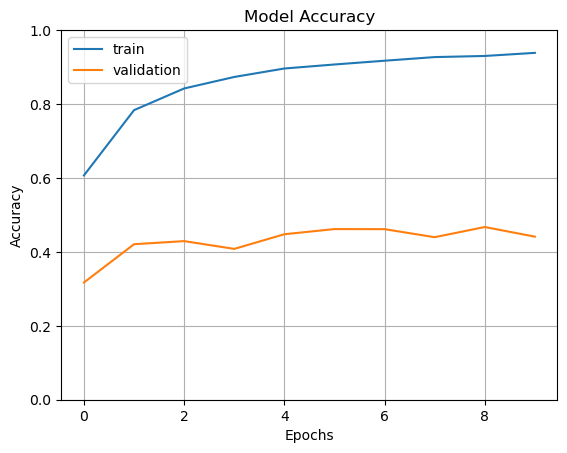

In [32]:
fig1 = plt.gcf()
plt.plot(history_5.history['sparse_categorical_accuracy'])
plt.plot(history_5.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model5_accuracy.png')
plt.show()

In [33]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net_5(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.36      0.43       768
           1       0.32      0.98      0.49       768
           2       0.80      0.21      0.33       768
           3       0.42      0.32      0.36       768
           4       0.52      0.67      0.59       768
           5       0.60      0.44      0.51       768
           6       0.42      0.10      0.17       768

    accuracy                           0.44      5376
   macro avg       0.52      0.44      0.41      5376
weighted avg       0.52      0.44      0.41      5376



In [ ]:
11